## Statistics for Value Mapping

In [1]:
import json
import Levenshtein
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, dirname

In [2]:
QUERY_DATASET_PATH = "../data/use_case1/dou.csv"
GDC_SCHEMA_PATH = "../data/use_case1/gdc_schema.json"
THRESHOLD = 3

column_mapping = {
    #"Proteomics_Participant_ID": "case_submitter_id",
    "Age": "age_at_diagnosis",
    "Gender": "gender",
    "Race": "race",
    "Ethnicity": "ethnicity",
    #"(none)": "(none)",
    "Histologic_Grade_FIGO": "tumor_grade",
    "tumor_Stage-Pathological": "ajcc_pathologic_stage",
    "Path_Stage_Reg_Lymph_Nodes-pN": "ajcc_pathologic_n",
    "Path_Stage_Primary_Tumor-pT": "ajcc_pathologic_t",
    "Tumor_Focality": "tumor_focality",
    "Tumor_Size_cm": "tumor_largest_dimension_diameter",
    "Tumor_Site": "tissue_or_organ_of_origin",
    "Histologic_type": "morphology",
    #"Case_excluded": "(none)"
}

def read_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
        
    return data

def plot_unique_values(dataset):
    # Calculate the number of unique values for each column
    unique_counts = dataset.nunique()
    
    # Plot the number of unique values for each column
    plt.figure(figsize=(10, 6))
    unique_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Columns')
    plt.ylabel('Number of Unique Values')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

gdc_schema = read_json(GDC_SCHEMA_PATH)

def get_gdc_values(column_name):
    for key, values in gdc_schema.items():
        for key in values["properties"].keys():
            if column_name == key:
                value_metadata = values["properties"][column_name]
                if "enum" in value_metadata:
                    return value_metadata["enum"]
                elif "type" in value_metadata and value_metadata["type"] == "number":
                    return []

    return None

def get_gdc_info(column_name):
    for key, values in gdc_schema.items():
        for key in values["properties"].keys():
            if column_name == key:
                value_metadata = values["properties"][column_name]
                return value_metadata

    return {}
    
def run_identical_match(current_values, gdc_values):
    matches = []
    
    for current_value in current_values:
        new_current_value = current_value.lower()
        for gdc_value in gdc_values:
            if new_current_value == gdc_value.lower():
                matches.append((current_value, gdc_value))
                break

    return matches

def run_levenhstein_match(current_values, gdc_values):
    matches = []
    
    for current_value in current_values:
        new_current_value = current_value.lower()
        if new_current_value == "nan": continue
        for gdc_value in gdc_values:
            if Levenshtein.distance(new_current_value, gdc_value.lower()) < THRESHOLD:
                matches.append((current_value, gdc_value))
                break

    return matches


### Query Dataset

In [3]:
query_dataset = pd.read_csv(QUERY_DATASET_PATH)
query_dataset = query_dataset[column_mapping.keys()]
query_dataset.head()

,Age,Gender,Race,Ethnicity,Histologic_Grade_FIGO,tumor_Stage-Pathological,Path_Stage_Reg_Lymph_Nodes-pN,Path_Stage_Primary_Tumor-pT,Tumor_Focality,Tumor_Size_cm,Tumor_Site,Histologic_type
0,64.0,Female,White,Not-Hispanic or Latino,FIGO grade 1,Stage I,pN0,pT1a (FIGO IA),Unifocal,2.9,Anterior endometrium,Endometrioid
1,58.0,Female,White,Not-Hispanic or Latino,FIGO grade 1,Stage IV,pNX,pT1a (FIGO IA),Unifocal,3.5,Posterior endometrium,Endometrioid
2,50.0,Female,White,Not-Hispanic or Latino,FIGO grade 2,Stage I,pN0,pT1a (FIGO IA),Unifocal,4.5,"Other, specify",Endometrioid
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carcinosarcoma
4,75.0,Female,White,Not-Hispanic or Latino,FIGO grade 2,Stage I,pNX,pT1a (FIGO IA),Unifocal,3.5,"Other, specify",Endometrioid


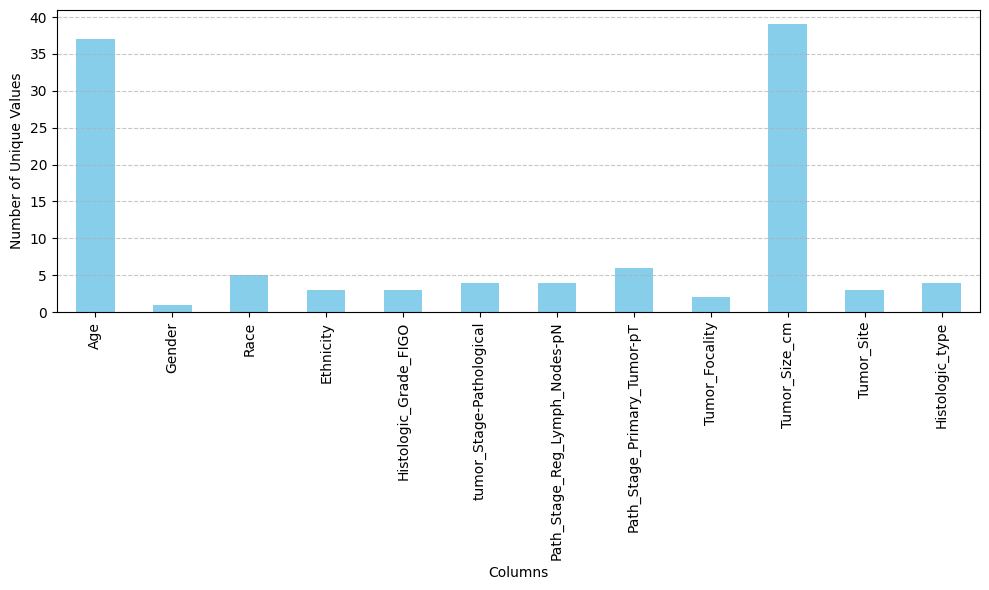

In [4]:
plot_unique_values(query_dataset)

In [5]:
def calculate_stats(match_method, verbose=False):
    total_values = 0
    total_matches = 0
    
    for current_name, gdc_name in column_mapping.items():
        gdc_values = get_gdc_values(gdc_name)
        current_values = set([str(x).strip() for x in query_dataset[current_name].unique()])
        if len(gdc_values) > 0:
            matches = match_method(current_values, gdc_values)
            if verbose:
                print(f"Column {current_name}")
                print(f"Current: {', '.join(current_values)}")
                print(f"GDC: {', '.join(gdc_values)}")
                print("Matches:", matches, "\n")
            total_values += len(current_values)
            total_matches += len(matches)
    percentage = round((total_matches * 100.0)/total_values, 2) 
    print(f"Found {total_matches} out of {total_values} matches ({percentage}%)")

### Baseline Mappings Coverage

In [6]:
print("Identical match:")
calculate_stats(run_identical_match)
print("Levenhstein match:")
calculate_stats(run_levenhstein_match)

Identical match:
Found 12 out of 44 matches (27.27%)
Levenhstein match:
Found 15 out of 44 matches (34.09%)


In [7]:
calculate_stats(run_identical_match, True)

Column Gender
Current: nan, Female
GDC: female, male, unknown, unspecified
Matches: [('Female', 'female')] 

Column Race
Current: Not Reported, White, Black or African American, Asian, nan
GDC: not reported, white, american indian or alaska native, black or african american, asian, native hawaiian or other pacific islander, other
Matches: [('Not Reported', 'not reported'), ('White', 'white'), ('Black or African American', 'black or african american'), ('Asian', 'asian')] 

Column Ethnicity
Current: nan, Not reported, Hispanic or Latino, Not-Hispanic or Latino
GDC: hispanic or latino, not hispanic or latino
Matches: [('Hispanic or Latino', 'hispanic or latino')] 

Column Histologic_Grade_FIGO
Current: FIGO grade 1, nan, FIGO grade 2, FIGO grade 3
GDC: G1, G2, G3, G4, GB, GX, High Grade, Intermediate Grade, Low Grade, Unknown, Not Reported
Matches: [] 

Column tumor_Stage-Pathological
Current: Stage I, Stage IV, Stage III, nan, Stage II
GDC: Stage 0, Stage 0a, Stage 0is, Stage I, Stage I

In [8]:
get_gdc_info("tumor_grade")

{'enum': ['G1',
  'G2',
  'G3',
  'G4',
  'GB',
  'GX',
  'High Grade',
  'Intermediate Grade',
  'Low Grade',
  'Unknown',
  'Not Reported'],
 'enumDef': {'G1': {'description': 'A morphologic qualifier indicating that a cancerous lesion is well differentiated.',
   'termDef': {'term': 'Grade 1',
    'source': 'NCIt',
    'cde_id': 'C28077',
    'cde_version': '20.05a',
    'term_url': 'https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C28077',
    'term_id': 'C28077',
    'term_version': '20.05a'}},
  'G2': {'description': 'A morphologic qualifier indicating that a cancerous lesion is moderately differentiated.',
   'termDef': {'term': 'Grade 2',
    'source': 'NCIt',
    'cde_id': 'C28078',
    'cde_version': '20.05a',
    'term_url': 'https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C28078',
    'term_id': 'C28078',
    'term_version': '20.05a'}},
  'G3': {'description': 'A morphologic qualifier i